In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pip install teeplot
from teeplot import teeplot as tp
from scipy.stats import kruskal
from IPython.display import display


# OSF identifier
data_id = "v3ec9"

# load CSV file into DataFrame directly from OSF URL
df = pd.read_csv(f"https://osf.io/{data_id}/download")


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


,T Upper Bound,H‑statistic,p‑value
0,steady,0.009,0.924382
1,stretched,0.196,0.657809
2,tilted,0.289,0.590676


teeplots/hue=t-upper-bound+palette=paired+viz=plot-mean-real-execution-time+x=algorithm+y=real-time-per-site-ns+ext=.pdf
teeplots/hue=t-upper-bound+palette=paired+viz=plot-mean-real-execution-time+x=algorithm+y=real-time-per-site-ns+ext=.png


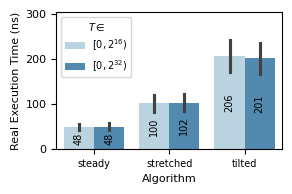

In [2]:
def plot_mean_real_execution_time(data, **kwargs):


    # rename the numeric T Upper Bounds
    data["T Upper Bound"] = data["T Upper Bound"].replace({
        65536: r"$[0, 2^{16})$",
        4294967296: r"$[0, 2^{32})$"
    })

    # Rename the algorithm labels
    data["Algorithm"] = data["Algorithm"].replace({
        "steady_lookup_ingest_times_batched": "steady",
        "stretched_lookup_ingest_times_batched": "stretched",
        "tilted_lookup_ingest_times_batched": "tilted"
    })

    # convert to microseconds per site
    data["Real Time Per Site (ns)"] = (data["Real Execution Time"] * 1e9) / (data["Surface Size (S)"] * data["T Size"])

    # group by Algorithm and T Upper Bound, compute the mean per-site time
    # grouped = data.groupby(["Algorithm", "T Upper Bound"], as_index=False)["Real Time Per Site (ns)"].mean()

    data_kw = data.copy()

    kruskal_results = []
    for bound, grp in data_kw.groupby("Algorithm"):
        # pull out each algorithm’s vector of times
        samples = [
            g["Real Time Per Site (ns)"].values
            for _, g in grp.groupby("T Upper Bound")
        ]
        stat, p_val = kruskal(*samples)
        kruskal_results.append({
            "T Upper Bound": bound,
            "H‑statistic": round(stat, 3),
            "p‑value": p_val
        })

    kruskal_df = pd.DataFrame(kruskal_results)
    display(kruskal_df)

    # bar plot
    plt.figure(figsize=(3, 2)) # these are IRL dimensions

    # more bar plot
    ax = sns.barplot(data=data, **kwargs, alpha=0.85)

    # Add labels to each bar
    # grab the x‑tick labels so we know which index is which algorithm
    algs = [lbl.get_text() for lbl in ax.get_xticklabels()]

    for container in ax.containers:
        for bar in container:
            h = bar.get_height()
            if h <= 0:
                continue
            # label text
            txt = f"{int(h)}"
            # bar center
            cx = bar.get_x() + bar.get_width() / 2
            cy = bar.get_y() + h / 2

            # figure out which algorithm this is by rounding cx to nearest tick
            idx = int(round(cx))
            alg = algs[idx] if 0 <= idx < len(algs) else None

            # nudge 'steady' bars down by 10 units (adjust as needed)
            offset = -2 if alg == "steady" else 0

            ax.text(
                cx,
                cy + offset,
                txt,
                ha="center",
                va="center",
                fontsize=7,
                rotation=90,
            )

    # better readability
    plt.xlabel("Algorithm", fontsize=8)
    plt.ylabel("Real Execution Time (ns)", fontsize=8)

    # keep x-axis labels horizontal
    plt.xticks(fontsize=7, rotation=0, ha='center')
    plt.yticks(fontsize=8)

    # ylim
    ax.set_ylim(0, ax.get_ylim()[1] * 1.2)

    # legend
    plt.legend(title=r"$T \in$", title_fontsize=7, fontsize=7, loc="upper left")

    # layout tweaks
    plt.subplots_adjust(bottom=0.4)
    plt.tight_layout(pad=1)


# teeplot
tp.tee(plot_mean_real_execution_time, data=df, x="Algorithm", y="Real Time Per Site (ns)", hue="T Upper Bound", palette="Paired")
